In [1]:
import numpy as np
import numpy.random as npr

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import autograd

from time import time

import gym
import gym_StochPendulum
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from xvfbwrapper import Xvfb
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900)).start()

In [2]:
class Config(object):
    batch_size = 256
    logging_frequency_train = 1
    logging_frequency_valid = 10
    clip_norm = True
    max_gradient_norm = 1.
    random_seed = 1234
    n_hidden = 32
    verbose = True
    
    n_state = 2
    T_terminal = 10.
    n_timestep = 200
    max_speed = 8.
    max_torque = 10.
    g = 10.
    m = 2.
    l = 0.5
    b = 0.1
    I = m * l**2
    sigma = [0., 1.]
    R = 0.1
    Q = [4., 0.05]
    G = [0., 1./I]
    target = [np.pi, 0.]
    init_state = [0., 0.]
    
    use_gpu = False
    if use_gpu:
        device = 'cuda:0'
    else:
        device = 'cpu'

In [3]:
class HJBNet(nn.Module):
    def __init__(self, n_in: int, n_out: int, n_hidden: int=256):
        super().__init__()
        self.HJB_net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_out)
        )
        
    def forward(self, t, x):
        z = torch.cat((t, x), dim=-1)
        return self.HJB_net(z)

In [4]:
class PendulumEnv():
    def __init__(self, cfg):
        self.g = cfg.g # gravitational acceleration
        self.m = cfg.m # pendulum mass
        self.l = cfg.l # pendulum arm length
        self.b = cfg.b # pendulum damping coefficient
        self.I = cfg.I # pendulum inertia
        self.max_speed = cfg.max_speed # maximum pendulum speed
        self.max_torque = cfg.max_torque # maximum applied torque (control)
        
        self.sigma = torch.Tensor( np.diag(cfg.sigma) ) # Gaussian noise added to pendulum velocity
        self.R = torch.Tensor( np.array([[cfg.R]]) )
        self.Q = torch.Tensor( np.array([cfg.Q]) )
        self.target = torch.Tensor( np.array([cfg.target]) )
        self.G = torch.Tensor( np.array([cfg.G]) )
    
    def cost(self, x, u): # M x D, M x 1
        batch_size = x.shape[0]
        Q = self.Q.repeat(batch_size, 1) # M x D
        target = self.target.repeat(batch_size, 1)
        R = self.R.repeat(batch_size, 1)

        state_cost = 0.5 * (Q*(x-target)**2).sum(dim=1, keepdim=True)
        control_cost = 0.5 * R * u**2
        return state_cost + control_cost # M x 1
    
    def terminal_cost(self, x): # M x D
        batch_size = x.shape[0]
        Q = self.Q.repeat(batch_size, 1)
        target = self.target.repeat(batch_size, 1)
        return 0.5 * (Q*(x-target)**2).sum(dim=1, keepdim=True) # M x 1
    
    def grad_terminal_cost(self, x): # M x D
        batch_size = x.shape[0]
        Q = self.Q.repeat(batch_size, 1)
        target = self.target.repeat(batch_size, 1)
        return Q * (x-target) # M x D
    
    def b_(self, x, u): # M x D, M x 1
        F = (-self.b/self.I)*x[:,1:2] - (self.g/self.l)*torch.sin(x[:,0:1]) #+torch.Tensor([np.pi])
        b0 = x[:,1:2].clone()
        b1 = F + u/self.I
        return torch.cat((b0, b1), dim=-1) # M x D
        
    def sigma_(self, batch_size):
        sigma_l = batch_size * [self.sigma]
        return torch.stack(sigma_l, dim=0) # M x D x D
    
    def optimal_control(self, v_x): # M x D
        batch_size = v_x.shape[0]
        R = self.R.repeat(batch_size, 1) # M x 1
        G = self.G.repeat(batch_size, 1) # M x D
        return -torch.div(1., R) * (G*v_x).sum(dim=1, keepdim=True) # M x 1
    
    def step(self, dt, dW, x, v, v_x): # M x 1, M x D, M x D, M x 1, M x D
        batch_size = x.shape[0]
        sigma_dW = torch.matmul(self.sigma_(batch_size), dW.unsqueeze(dim=-1)).squeeze(dim=-1)
        
        u_opt = self.optimal_control(v_x) # M x 1
        u_opt = torch.clamp(u_opt, -self.max_torque, self.max_torque)
        
        h = self.cost(x, u_opt) # M x 1
        
        def forward_sde():
            return x + self.b_(x, u_opt)*dt + sigma_dW
        
        def backward_sde():
            return v - h*dt + (v_x*sigma_dW).sum(dim=1, keepdim=True)
        return forward_sde(), backward_sde(), h, u_opt

In [5]:
class DeepFBSDE():
    def __init__(self, cfg):
        self.cfg = cfg
        torch.manual_seed(self.cfg.random_seed)
        npr.seed(self.cfg.random_seed)
        self.cost_history = []
        self.loss_history = []
        
        self.T = self.cfg.T_terminal
        self.M = self.cfg.batch_size
        self.N = self.cfg.n_timestep
        self.D = self.cfg.n_state
        
        self.max_speed = self.cfg.max_speed
        self.max_torque = self.cfg.max_torque
        self.g = self.cfg.g
        self.m = self.cfg.m
        self.l = self.cfg.l
        self.init_state = self.cfg.init_state
        
        self.device = torch.device(self.cfg.device)
        
        print('Using Pendulum environment')
        self.env = PendulumEnv(self.cfg)
        
        print(f'Using a batch size of {self.M} episodes')
        self.Vnet = HJBNet(n_in=self.D+1, n_out=1, n_hidden=self.cfg.n_hidden).to(self.device)
        
        print('\nModel trainable paramaters:')
        for name, param in self.Vnet.named_parameters():
            if param.requires_grad:
                print(name, ', shape:', list(param.shape))
        print('\n')
        
    def reset(self, batch_size):
        high = np.repeat(np.array([self.init_state]), batch_size, axis=0)
        Xi = npr.uniform(low=-high, high=high)
        return Xi

    def net_v_z(self, t, x): # M x 1, M x D
        v = self.Vnet(t, x) # M x 1
        z = autograd.grad(outputs=v, inputs=x, grad_outputs=torch.ones_like(v), create_graph=True)[0] # M x D
        return v, z
        
    def loss_function(self, t, Xi, W):
        cost_tot = 0
        X_list = []
        Y_list = []
        U_list = []
        
        t0 = t[:,0,:] # M x 1
        W0 = W[:,0,:] # M x D
        X0 = Xi # M x D
        Y0, Z0 = self.net_v_z(t0, X0) # output: M x 1, M x D
        
        X_list.append(X0)
        Y_list.append(Y0)
        
        for n in range(0, self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            dt = t1 - t0
            dW = W1 - W0
            
            X1, Y1, cost, U_opt = self.env.step(dt, dW, X0, Y0, Z0)
            
            _, Z1 = self.net_v_z(t1, X1)

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1
            
            cost_tot += cost.mean()
            X_list.append(X0)
            Y_list.append(Y0)
            U_list.append(U_opt)
            
        loss = F.mse_loss(input=Y1, target=self.env.terminal_cost(X1)) + \
               F.mse_loss(input=Z1, target=self.env.grad_terminal_cost(X1))

        X = torch.stack(X_list, dim=1).squeeze()
        Y = torch.stack(Y_list, dim=1).squeeze()
        U = torch.stack(U_list, dim=1).squeeze()
        return loss, cost_tot, X, Y, U
        
    def fetch_batch(self, batch_size):    
        T = self.T
        M = batch_size
        N = self.N
        D = self.D
        
        Dt = np.zeros((M, N+1, 1))
        DW = np.zeros((M, N+1, D))
        Xi = self.reset(batch_size)
        
        dt = T / N
        Dt[:,1:,:] = dt
        DW[:,1:,:] = np.sqrt(dt) * npr.normal(size=(M, N, D))
        
        t = np.cumsum(Dt, axis=1) # M x (N+1) x 1
        W = np.cumsum(DW, axis=1) # M x (N+1) x D
        
        t_batch = torch.as_tensor(t, dtype=torch.float, device=self.device).requires_grad_(True)
        Xi_batch = torch.as_tensor(Xi, dtype=torch.float, device=self.device).requires_grad_(True)
        W_batch = torch.as_tensor(W, dtype=torch.float, device=self.device)
        return t_batch, Xi_batch, W_batch
    
    def train_loop(self, n_epoch, init_lr_value, fixed_lr=True, l2_reg=0.):
        opt = optim.Adam(params=[{'params': self.Vnet.parameters()}], lr=init_lr_value, weight_decay=l2_reg)
        if fixed_lr:
            print('Using a fixed learning rate of:', init_lr_value)
            lr_sched = ReduceLROnPlateau(opt, 'min', patience=1000, factor=0.9999, verbose=True)
        else:
            lr_sched = ReduceLROnPlateau(opt, 'min', patience=10, factor=0.75, verbose=True)
            
        epoch = 0
        while epoch < n_epoch:
            iter_start_time = time()
            t_batch, Xi_batch, W_batch = self.fetch_batch(batch_size=self.M)
            loss, _, _, _, _ = self.loss_function(t_batch, Xi_batch, W_batch)
            opt.zero_grad()
            loss.backward(retain_graph=True)
            if self.cfg.clip_norm:
                nn.utils.clip_grad_norm_(self.Vnet.parameters(), self.cfg.max_gradient_norm)
            opt.step()
            epoch += 1
            
            if epoch%self.cfg.logging_frequency_valid == 0:
                iter_time = time() - iter_start_time
                t_batch, Xi_batch, W_batch = self.fetch_batch(batch_size=self.M)
                loss, cost, _, _, _ = self.loss_function(t_batch, Xi_batch, W_batch)
                lr_sched.step(loss)
                self.loss_history.append(loss)
                self.cost_history.append(cost)
                self.lr = opt.param_groups[0]['lr']
                print(f'validation epoch: {epoch}, NN loss: {loss:0.3e}, Avg. cost: {cost:0.3e} ' +
                      f'time/iter: {iter_time:0.3e} s')
        return
    
    def predict(self, n_episode):
        t_test, Xi_test, W_test = self.fetch_batch(batch_size=n_episode)
        test_loss, test_cost, X_pred, v_pred, u_pred = self.loss_function(t_test, Xi_test, W_test)
        
        t_test = t_test.squeeze(dim=-1).cpu().data.numpy()
        X_pred = X_pred.cpu().data.numpy()
        v_pred = v_pred.cpu().data.numpy()
        u_pred = u_pred.cpu().data.numpy()
        return t_test, X_pred, v_pred, u_pred, test_loss, test_cost

In [6]:
cfg = Config()
model = DeepFBSDE(cfg)

Using Pendulum environment
Using a batch size of 256 episodes

Model trainable paramaters:
HJB_net.0.weight , shape: [32, 3]
HJB_net.0.bias , shape: [32]
HJB_net.2.weight , shape: [32, 32]
HJB_net.2.bias , shape: [32]
HJB_net.4.weight , shape: [1, 32]
HJB_net.4.bias , shape: [1]




In [16]:
model.train_loop(n_epoch=800, init_lr_value=1e-3, fixed_lr=True, l2_reg=0.0001)

Using a fixed learning rate of: 0.001
validation epoch: 10, NN loss: 3.345e+01, Avg. cost: 3.122e+02 time/iter: 1.345e+00 s
validation epoch: 20, NN loss: 2.587e+01, Avg. cost: 3.082e+02 time/iter: 1.303e+00 s
validation epoch: 30, NN loss: 1.665e+01, Avg. cost: 3.022e+02 time/iter: 1.298e+00 s
validation epoch: 40, NN loss: 1.011e+01, Avg. cost: 2.955e+02 time/iter: 1.455e+00 s
validation epoch: 50, NN loss: 5.166e+00, Avg. cost: 2.933e+02 time/iter: 1.311e+00 s
validation epoch: 60, NN loss: 3.143e+00, Avg. cost: 2.965e+02 time/iter: 1.277e+00 s
validation epoch: 70, NN loss: 1.701e+00, Avg. cost: 2.920e+02 time/iter: 1.410e+00 s
validation epoch: 80, NN loss: 5.102e-01, Avg. cost: 2.928e+02 time/iter: 1.288e+00 s
validation epoch: 90, NN loss: 8.196e-01, Avg. cost: 3.057e+02 time/iter: 1.428e+00 s
validation epoch: 100, NN loss: 4.528e-01, Avg. cost: 2.928e+02 time/iter: 1.409e+00 s
validation epoch: 110, NN loss: 5.034e-01, Avg. cost: 2.957e+02 time/iter: 1.488e+00 s
validation epo

In [8]:
# torch.save(model.Vnet.state_dict(), './saved-models/torch-model')

In [9]:
# NN = HJBNet(n_in=cfg.n_state+1, n_out=1, n_hidden=cfg.n_hidden)
# NN.load_state_dict(torch.load('./saved-models/torch-model'))
# NN.eval()

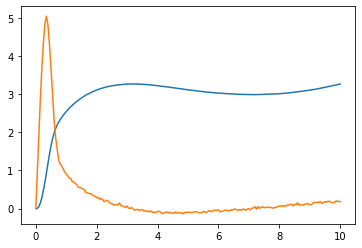

In [17]:
t_pred, X_pred, v_pred, u_pred, loss, cost = model.predict(128)

plt.plot(t_pred[0,:], X_pred.mean(axis=0))

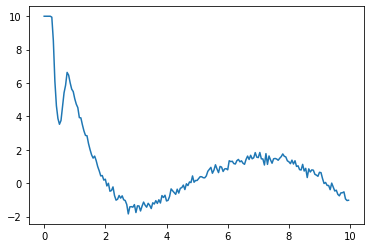

In [18]:
plt.plot(t_pred[0,:-1], u_pred.mean(0))

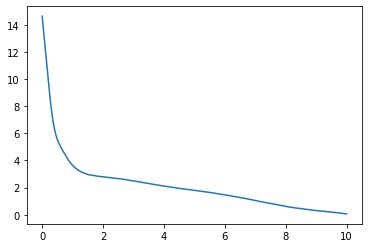

In [19]:
plt.plot(t_pred[0,:], v_pred.mean(0))

In [20]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [22]:
dt = cfg.T_terminal / cfg.n_timestep
sigma = cfg.sigma[1]
kwargs = {'sigma': sigma, 'dt': dt}
eval_env = wrap_env(gym.make('StochPendulum-v0', **kwargs))

t = 0
episodic_reward = 0
prev_state = eval_env.reset()
torch_t = torch.Tensor( np.array( [[t]] ) )
prev_state = np.array( [[prev_state[0], prev_state[1]]] )
torch_prev_state = torch.Tensor(prev_state).requires_grad_(True)
_, z = model.net_v_z(torch_t, torch_prev_state)

for n in range(cfg.n_timestep):
    eval_env.render()
    action = model.env.optimal_control(z)
    state, reward, done, info = eval_env.step(action.detach().numpy()[0])
    episodic_reward += -reward
    t += dt
    prev_state = np.array( [[state[0], state[1]]] )
    if done:
        print(f'Episode finished after {t:.3f} seconds with cost = {episodic_reward:.3f}')
        break
    torch_t = torch.Tensor(np.array( [[t]] ))
    torch_prev_state = torch.Tensor(prev_state).requires_grad_(True)
    _, z = model.net_v_z(torch_t, torch_prev_state)
eval_env.close()
show_video()

Episode finished after 10.000 seconds with cost = 285.442
